In [1]:
## downloading the dataset
!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz

--2023-07-12 18:55:29--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5264982680 (4.9G) [application/x-xz]
Saving to: ‘mvtec_anomaly_detection.tar.xz’

mvtec_anomaly_detec 100%[===================>]   4.90G  7.70MB/s    in 9m 6s   

2023-07-12 19:04:36 (9.20 MB/s) - ‘mvtec_anomaly_detection.tar.xz’ saved [5264982680/5264982680]



In [5]:
## uncompressing the tar files
!tar xf /content/mvtec_anomaly_detection.tar.xz -C /content/data

In [6]:
'''
    Zero_shot_learning
    ------------------
    > Here we have a anomaly dataset.
        > classes are defects and non-detects dataset.

    > Here we will use the pretrained models
'''
## importing the modules
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sbn
import cv2
import keras
import random


In [7]:



## Configurations
class CNF:
    seed = 42
    data_folder = "/content/data"  ### replace with your training data folder
    target_shape = (224, 224)
    labels = True # using labels or not.


    ### dataset configs
    buffer_size = 1024
    batch_size = 32
    validation_size = 0.2 ## 20% of data from the training dataset.

    ### training hyperparameters
    learning_rate = 0.00001

### setting the reproducability
def seeding():
    np.random.seed = CNF.seed
    tf.random.set_seed(CNF.seed)

    print("| Seeding Done.")

### reproduciblity
seeding()
CNF.classes = [d for d in os.listdir(CNF.data_folder) if os.path.isdir(os.path.join(CNF.data_folder, d))]
char_int = dict((k,v) for v,k in enumerate(CNF.classes))
int_char = dict((v,k) for v,k in enumerate(CNF.classes))

# build a lookup table
table_char_int = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(char_int.keys())),
        values=tf.constant(list(char_int.values())),
    ),
    default_value=tf.constant(-1),
    name="classes"
)


### Detecting the GPU and Setting distribution strategy based on the GPU or CPU.
gpus = tf.config.experimental.list_logical_devices('GPU')
if(len(gpus)>0):
    CNF.device = "GPU"
    strategy = tf.distribute.MirroredStrategy(devices=gpus)
    print("> Running on {} | Number of devices {}".format(CNF.device, len(gpus)))

else:
    CNF.device = "CPU"
    strategy = tf.distribute.get_strategy() ## here we are getting the default strategy.
    print("> Running on {}".format(CNF.device))

print("> Number of replicas : ", strategy.num_replicas_in_sync)


## preparing the dataset
class Prepare_dataset:

  '''
      Here we will prepare the dataset using
      > Here we will create a data loaders
      > and data generator.
      > we will also apply data augmentation too
  '''
  def __init__(self):
    self.training_data_paths = None
    self.evaluation_data_paths = None
    self.classes = None

  def get_training_data_paths(self):
    paths = glob(os.path.join(CNF.data_folder,"**","train", "good","**.png"))
    self.training_data_paths = paths

  def get_evaluation_data_paths(self):
    paths = glob(os.path.join(CNF.data_folder, "**", "test", "*","**.png"))
    self.evaluation_data_paths = paths



  def data_generator(self, train_paths):

    def load_preprocess(path):
        image=tf.io.read_file(path)
        image = tf.io.decode_png(image, channels=3)
        image = tf.keras.preprocessing.image.smart_resize(image, size = CNF.target_shape)
        # print(image.shape)
        return image/255

    def get_label(path):
        # print(path.numpy())
        parts = tf.strings.split(path, os.path.sep)
        label = parts[-4]
        # print(label)
        ### convert it into the hard label using char to int dictonary
        out = table_char_int.lookup(label)
        return tf.one_hot(out, depth=len(CNF.classes))


    if(CNF.labels):
      image = load_preprocess(train_paths)
      label = get_label(train_paths)
      return image, label

    else:
      image= load_preprocess(train_paths)
      return image



  def train_val_data_loader(self):
    data_paths = random.sample(self.training_data_paths, len(self.training_data_paths))
    train_data_paths = data_paths[:int(len(self.training_data_paths)*(1- CNF.validation_size))]
    val_data_paths = data_paths[int(len(self.training_data_paths)*(1- CNF.validation_size)):]

    ### training data loaders
    dataset = tf.data.Dataset.from_tensor_slices(train_data_paths)
    dataset = dataset.map(self.data_generator)
    dataset = dataset.shuffle(CNF.buffer_size)
    dataset = dataset.batch(CNF.batch_size)

    ### validation data loaders
    val_dataset = tf.data.Dataset.from_tensor_slices(val_data_paths)
    val_dataset = val_dataset.map(self.data_generator)
    val_dataset = val_dataset.shuffle(CNF.buffer_size)
    val_dataset = val_dataset.batch(CNF.batch_size)

    return dataset, val_dataset


#### Sanity check

if __name__ == "__main__":

    ppd = Prepare_dataset()
    ppd.get_training_data_paths()
    ppd.get_evaluation_data_paths()

    # img, label = ppd.data_generator(ppd.training_data_paths[0])

    dataset, val_dataset = ppd.train_val_data_loader()



| Seeding Done.
> Running on GPU | Number of devices 1
> Number of replicas :  1


In [8]:
### sanity-check data loaders
k = iter(dataset)
kk = next(k)

### Few-shot Learnining
> Using a pretrained model as a Base Network.

Steps for achieving a contrastive Learning:
___
1. Finetuning a pretrained network for achieving the multi classification problem.
2. Using some similarity metric detecting defects and non-defects.

In [9]:
### getting the ResNet Model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(CNF.target_shape[0], CNF.target_shape[1], 3)
)

## freezing the network.
base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [10]:
### summay of the network
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [11]:
Model_nets = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units = 128, activation="relu", name = "embed_layer"),
    tf.keras.layers.Dense(units = 15, activation = "softmax")
])

In [12]:
Model_nets.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 embed_layer (Dense)         (None, 128)               163968    
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 2,423,887
Trainable params: 165,903
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
## Training the Model in Multi-classification way.
## compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=CNF.learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = tf.keras.metrics.CategoricalAccuracy()

Model_nets.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

In [14]:
Model_nets.fit(dataset, epochs=4, validation_data=val_dataset)

Epoch 1/4
91/91 [==============================] - 138s 1s/step - loss: 2.5464 - categorical_accuracy: 0.2590 - val_loss: 2.1207 - val_categorical_accuracy: 0.4408
Epoch 2/4
91/91 [==============================] - 134s 1s/step - loss: 1.7790 - categorical_accuracy: 0.6149 - val_loss: 1.4639 - val_categorical_accuracy: 0.7590
Epoch 3/4
91/91 [==============================] - 124s 971ms/step - loss: 1.2089 - categorical_accuracy: 0.8412 - val_loss: 0.9922 - val_categorical_accuracy: 0.9008
Epoch 4/4
91/91 [==============================] - 123s 992ms/step - loss: 0.8201 - categorical_accuracy: 0.9321 - val_loss: 0.6816 - val_categorical_accuracy: 0.9477


### One-shot learning to detect defets by the similarity Metric:

Step 1: Building the Embedded store.

    - Embedded model , get the embedding of training data and store as a key points.
  
Step 2: Classify and detect defects of the testing dataset.

    - Classify the Image of test data
    - Get the Embeddings of the test image.
    - Calculate the similarity distance with the embeddings of classified class.

**Step 1.1 : Embedding Model**

In [35]:
## Embedding Network
Embed_model = tf.keras.Model(inputs= Model_nets.inputs, outputs = Model_nets.get_layer("embed_layer").output)
Embed_model.trainable = False
Embed_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224_input   [(None, 224, 224, 3)]    0         
 (InputLayer)                                                    
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 embed_layer (Dense)         (None, 128)               163968    
                                                                 
Total params: 2,421,952
Trainable params: 0
Non-trainable params: 2,421,952
_________________________________________________

In [37]:
### getting the training sample from each class, get the embeddings from those classes
train_embed_samples = []
for c in CNF.classes:
  paths = random.sample(glob(os.path.join(CNF.data_folder , c, "train", "good", "*.png")),1)
  train_embed_samples.append(paths[0])



In [38]:
## training samples for base embeddings.
train_embed_samples

### Embedded Store
train_embeds = {}


for p in train_embed_samples:
  x,y = ppd.data_generator(p)
  x = np.expand_dims(x.numpy(), axis = 0)
  y = np.argmax(y.numpy())
  train_embeds[y]= Embed_model.predict(x)[0]


1/1 [==============================] - 0s 22ms/step


In [18]:
train_embeds[0].shape

(128,)

**Step 2.1: Preparing the test dataset**

In [97]:
## here we are preparing the data frames

class_labels = []
anomaly_labels = []

for path in ppd.evaluation_data_paths:
  chuncks = path.split("/")
  if(chuncks[-2] !="good"):
    anomaly_labels.append("defect")
  else:
    anomaly_labels.append("not_defect")

  class_labels.append(chuncks[-4])

test_df = pd.DataFrame()
test_df["paths"] = ppd.evaluation_data_paths
test_df["class_labels"] = class_labels
test_df["anomaly_labels"] =  anomaly_labels

**Step 2.2: Classify the test images**

In [98]:
## Read the images from tthe test files
test_images = []
for img_path  in tqdm(test_df["paths"]):
  x,y = ppd.data_generator(img_path)
  test_images.append(x)


100%|██████████| 1725/1725 [01:30<00:00, 19.12it/s]


In [99]:
test_images = np.array(test_images)

In [100]:
### Predicting the classes from the images
predict_class = Model_nets.predict(test_images)
predict_class = np.argmax(predict_class, axis=1)

54/54 [==============================] - 2s 40ms/step


In [101]:
predict_class

array([ 0,  0,  0, ..., 14, 14, 14])

**Step 2.3: Get the Emeddings for the test images**

In [102]:
predict_embeds = Embed_model.predict(test_images)

54/54 [==============================] - 2s 33ms/step


**Step 2.4: Getting in a single DataFrame**

In [103]:
test_df["classes_predicted"] = predict_class.tolist()
test_df["test_embeddings"] = predict_embeds.tolist()
test_df["class_labels"]  = test_df["class_labels"].map(char_int)
test_df["actual_train_embeddings"] = test_df["class_labels"].map(train_embeds)
test_df["predicted_train_embeddings"] = test_df["classes_predicted"].map(train_embeds)


In [104]:
test_df.head()

,paths,class_labels,anomaly_labels,classes_predicted,test_embeddings,actual_train_embeddings,predicted_train_embeddings
0,/content/data/cable/test/cable_swap/006.png,0,defect,0,"[1.7182416915893555, 0.0, 0.0, 0.3349319994449...","[2.065902, 0.0, 0.0, 0.21686272, 0.80396324, 0...","[2.065902, 0.0, 0.0, 0.21686272, 0.80396324, 0..."
1,/content/data/cable/test/cable_swap/003.png,0,defect,0,"[1.8104884624481201, 0.0, 0.006706684362143278...","[2.065902, 0.0, 0.0, 0.21686272, 0.80396324, 0...","[2.065902, 0.0, 0.0, 0.21686272, 0.80396324, 0..."
2,/content/data/cable/test/cable_swap/011.png,0,defect,0,"[2.708906412124634, 0.0, 0.0, 0.18039876222610...","[2.065902, 0.0, 0.0, 0.21686272, 0.80396324, 0...","[2.065902, 0.0, 0.0, 0.21686272, 0.80396324, 0..."
3,/content/data/cable/test/cable_swap/010.png,0,defect,0,"[0.815099835395813, 0.0, 0.3783508241176605, 0...","[2.065902, 0.0, 0.0, 0.21686272, 0.80396324, 0...","[2.065902, 0.0, 0.0, 0.21686272, 0.80396324, 0..."
4,/content/data/cable/test/cable_swap/008.png,0,defect,0,"[2.0315659046173096, 0.0, 0.0, 0.9730851650238...","[2.065902, 0.0, 0.0, 0.21686272, 0.80396324, 0...","[2.065902, 0.0, 0.0, 0.21686272, 0.80396324, 0..."


In [105]:
tf.keras.metrics.Accuracy()(test_df["class_labels"].values, test_df["classes_predicted"].values)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9101449>

In [106]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

In [107]:
### Assuming the classes are Known for the test dataset.
simil_known_class = []

for i, j in zip(test_df["actual_train_embeddings"].values, test_df["test_embeddings"].values):
  s = cosine_similarity(np.expand_dims(i, axis=0),np.expand_dims(j, axis = 0))
  simil_known_class.append(s.tolist()[0])

In [108]:
### Assuming the classes are unknown --> Here the classes are predicted from multi-classification model

simil_unknown_class = []

for i, j in zip(test_df["predicted_train_embeddings"].values, test_df["test_embeddings"].values):
  s = cosine_similarity(np.expand_dims(i, axis=0),np.expand_dims(j, axis = 0))
  simil_unknown_class.append(s.tolist()[0])

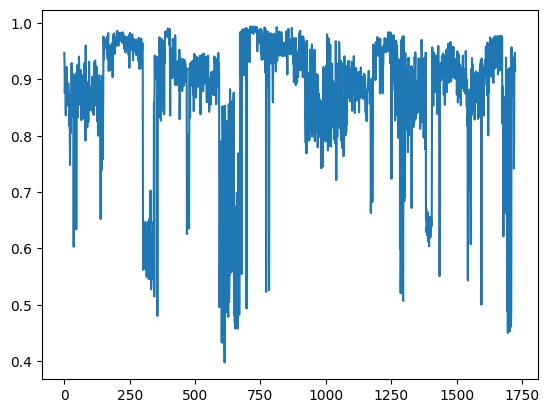

In [109]:
### similarity checking for classes are unknown
plt.plot(simil_unknown_class)

In [150]:
### For detecting the defects and non-defects, we are keeping a threshold
detect_defect_threshold = 0.95

anomalies_preds = (np.array(simil_unknown_class)<detect_defect_threshold).astype(int)

**Defect labels representations**
- 1--> Defect
- 0 --> Not Defect

In [151]:
pred_anomalies = [i[0] for i in anomalies_preds]
# test_df["predicts_anomalies"] = anomalies

In [152]:
act_anomalies = test_df["anomaly_labels"].map({"defect":1,"not_defect":0 })

#### Evaluation Metrics

In [153]:
from sklearn.metrics import f1_score, accuracy_score

In [154]:
print("The Accuracy score for zero-shot learning : ", accuracy_score(act_anomalies,pred_anomalies))
print("The F1- score for zero-shot learning : ", f1_score(act_anomalies,pred_anomalies))

The Accuracy score for zero-shot learning :  0.6469565217391304
The F1- score for zero-shot learning :  0.7618302698474776
